<a href="https://colab.research.google.com/github/sejongsmarcle/2023_Spring_Kaggle_Study/blob/main/%EA%B9%80%ED%96%A5%EC%9E%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="2"></a>
# **<center><span style="color:#00BFC4;">Imports  </span></center>**

필요한 라이브러리를 임포트함

In [1]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

clear_output()

***clear_output***

그림도 띄우고 tqdm으로 진행과정도 함께 보고싶을 때 사용하는 라이브러리

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


#from lightgbm import LGBMClassifier
import lazypredict
#from lazypredict.Supervised import LazyClassifier

# lightgbm, lazypredic가 안됨 .. ! 이유는 모르겠음 이 오류의 연장선으로 밑에 있는 애들도 지금 안됨...

import time
import warnings
warnings.filterwarnings('ignore')



📌 선 그래프
```
import plotly.express as px
```

📌반응형, 오픈소스, 브라우저 기반 시각화 라이브러리 **plotly**

```
import plotly.graph_objects as go
from plotly.subplots import make_subplots
```





📌 sklearn pakage

1. from sklearn.impute : 결측 데이터 채워넣기
2. from sklearn.metrics : 분류 성능 평가
3. from sklearn.preprocessing : 스케일링, 변환
4. from sklearn.model_selection : 데이터 분할 

<a id="3"></a>
# **<center><span style="color:#00BFC4;">Data Loading and Preparation </span></center>**

-  train, test, submission set load
-  head(), sort_value(), describe() func를 이용해서 데이터 리뷰 & 결측치 확인

In [3]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

### <span style="color:#e76f51;"> Quick view of Train Data : </span>

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


### <span style="color:#e76f51;"> Column Wise missing values : </span>

In [6]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


### <span style="color:#e76f51;"> Basic statistics of training data : </span>

In [7]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### <span style="color:#e76f51;"> Quick view of Test Data </span>

In [8]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [9]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values  in test data: {sum(test.isna().sum())}')

Number of rows in test data: 4277
Number of columns in test data: 13
Number of values in train data: 54484
No of rows with missing values  in test data: 1117


### <span style="color:#e76f51;"> Column Wise missing values </span>

In [10]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False)))


FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


### <span style="color:#e76f51;"> Basic statistics of test data </span>

In [11]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


### <span style="color:#e76f51;"> Quick view of Submission File </span>

In [12]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


<a id="4"></a>
# **<center><span style="color:#00BFC4;"> EDA </span></center>**

데이터 분석 및 전처리

참고 자료 
- https://chancoding.tistory.com/229
- https://wikidocs.net/188126

<a id="4.1"></a>
## <span style="color:#e76f51;"> Overview of Data </span>

In [13]:
train.drop(["PassengerId"] , axis = 1 , inplace = True)
test.drop(["PassengerId"] , axis = 1 , inplace = True)
# train, test set의 PassengerID 열 제거

TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12 

**Random_state** 

: 호출할 때마다 동일한 학습/테스트용 데이터 세트를 생성하기 위해 주어지는 난수 값

In [14]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')
                     
# train set의 describe 값을 색을 이용해서 시각화

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


<a id="4.7"></a>
## <span style="color:#e76f51;"> Null Value Distribution  </span>

NULL 값 분포 시각화

<a id="4.2.1"></a>
### <span style="color:#e76f51;">Column wise Null Value Distribution   </span>

열 별 NULL값 분포 시각화

In [15]:
# test set의 NULL 값
test_null = pd.DataFrame(test.isna().sum()) 
test_null = test_null.sort_values(by = 0 ,ascending = False) 

# train set의 NULL 값 
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1]

# make_subplots 함수를 이용해서 서브 플롯 생성
fig = make_subplots(rows=1,  # row, cols 이용해서 행렬 개수 설정
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

# add_trace를 이용해서 그래프 추가하면 됨 (여기서는 그래프 2개)
fig.add_trace(go.Bar(x=train_null[0], # go.bar () : add_trace 안에 넣는 Bar Trace
                     y=train_null.index,
                     orientation="h", # 수평 막대 설정 (h)
                    marker=dict(color=[n for n in range(12)],  # 마커 색,두께,coloraxis 설정 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

# update_layout() : 그래프 생성 완료 후 layout 정보를 업데이트 하는 함수
fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

<a id="4.7.2"></a>
### <span style="color:#e76f51;">Row wise Null Value Distribution   </span>

행 별 NULL 값 분포 시각화

In [17]:
# test set row의 NULL 값
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()

missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100

# 열 값 시각화 한 과정과 동일함
fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

<a id="4.2"></a>
## <span style="color:#e76f51;">Continuos and Categorical Data Distribution </span>

연속, 카테고리 자료 분류 시각화

In [18]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

del df
# feature, cat_feature, cont_feature, text_feature 값 출력
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

# 라벨, 값, 색 지정
labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

# go.Figure 함수를 통해 그래프 생성
fig = go.Figure(data=[go.Pie( # pie 함수 생성
    labels=labels,  # 위에 설정한 parameter 사용 
    values=values, pull=[0.1, 0, 0 ], # pull : 조각 별 거리를 순서대로 리스트 형태로 넣음
    marker=dict(colors=colors, 
                line=dict(color='#000000',  # 테두리 색, 두께 지정
                          width=2))
)])
fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


<a id="4.3"></a>
## <span style="color:#e76f51;"> Feature Distribution of Continous Features </span>


### <span style="color:#e76f51;">  Distribution of Age </span>

In [19]:
train_age = train.copy() #df.copy() : df 복사본 만들기
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age]) #df.concat : 데이터 합치기 
fig = px.histogram(data_frame = ageDf,  # px.histogram : 히스토그램 그리기
                   # data_frame : 
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5) # 레이아웃 업데이트
fig.show()

<a id="4.4"></a>
## <span style="color:#e76f51;">  Feature Distribution of Categorical Features </span>

위의 오류 때문에 구현이 안됨 .. . . . ㅠㅠ

ValueError: ignored

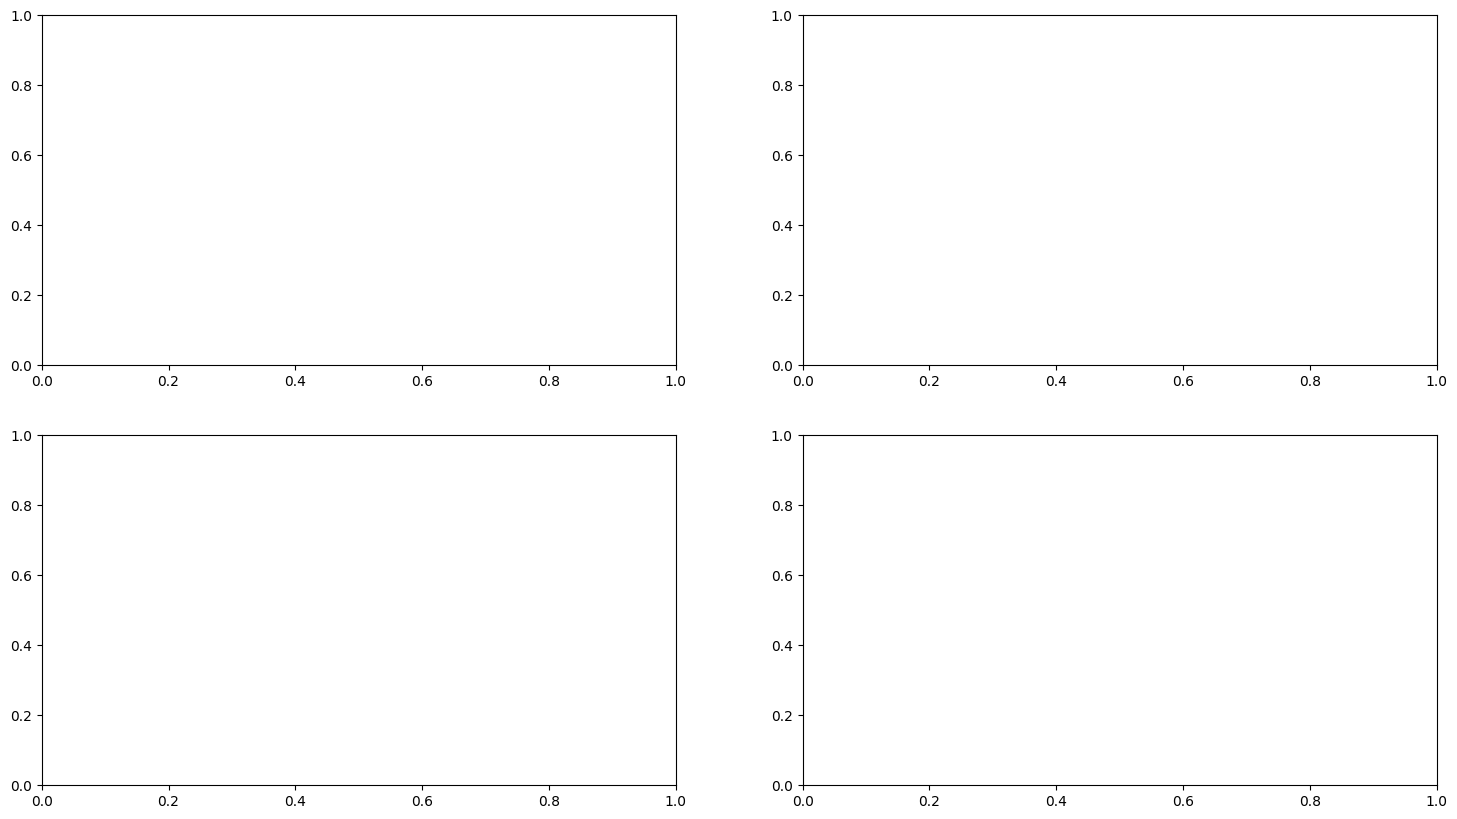

In [20]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col],ax = axes[r,c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[r,c] ,palette = "magma", label='Test data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

<a id="4.5"></a>
## <span style="color:#e76f51;">  Target Distribution </span>

타겟 분포 시각화

In [21]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count'] # colum 설정
fig = px.bar(data_frame =target_df,  # px.bar : bar형 그래프 설정 
             x = TARGET,
             y = 'count'
            ) 
# add_trace를 이용해서 그래프 추가
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)

# update_layout을 이용해서 그래프 정보 업데이트
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


<a id="4.6"></a>
## <span style="color:#e76f51;">  Correlation matrix </span>

위의 오류 때문에 구현 불가..

In [22]:
fig = px.imshow(train.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

ValueError: ignored

<a id="5"></a>
# **<center><span style="color:#00BFC4;">Data Pre-Processing  </span></center>**

참고 자료 
- https://for-my-wealthy-life.tistory.com/18

### <span style="color:#e76f51;"> Imputing Missing Values </span>

NaN 값 대치

In [23]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy=STRATEGY) # 결측값 대치 
imputer.fit(train[imputer_cols]) # train의 imputer_cols로 fit
train[imputer_cols] = imputer.transform(train[imputer_cols]) #변환된 feature들을 포함한 평이한 numpy 배열 
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

### <span style="color:#e76f51;">Encoding Categorical Features </span>

카테고리 인코딩 과정

In [24]:
label_cols = ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]
# label_encoding 함수 설정
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str) #train과 test의 자료형 변환 
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col]) #fit_transform()은 말그대로 fit()과 transform()을 한번에 처리할 수 있게 하는 메서드
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test 

train ,test = label_encoder(train,test ,label_cols)

In [25]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

train, test set에서 값 drop 후 학습